# Recommendations with IBM

This notebook will build a recommendation engine to be used on real data from the IBM Watson Studio platform. Recommendations will be made based on different approaches.

- Ranked based recommendations (articles with most user interactions)
- Collaborative filtering recommendations (finding similar users and suggesting articles not seen by one)
- Content based recommendations (classifying articles of interest and recommending articles in that category which have not been seen by the user)
- Finally we will look at predictive recommendations using Singular Value Decomposition (SVD)

The data for this project was provided by [Udacity Data Science Nanodgree](https://www.udacity.com/course/data-scientist-nanodegree--nd025) in partnership with IBM Watson Studio


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [References](#References)

### Import necessary libraries and data

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import joblib

%matplotlib inline

import re
from pprint import pprint

# nltk
import nltk
nltk.download(['punkt', 'wordnet', 'averaged_perceptron_tagger'])

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

df = pd.read_csv('user-item-interactions.csv')
df.article_id = df['article_id'].astype(str)
df_content = pd.read_csv('articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head(2)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/benfarrell/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/benfarrell/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/benfarrell/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b


In [93]:
df.user_id.nunique()

5149

In [96]:
df_content.article_id.nunique()

1051

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

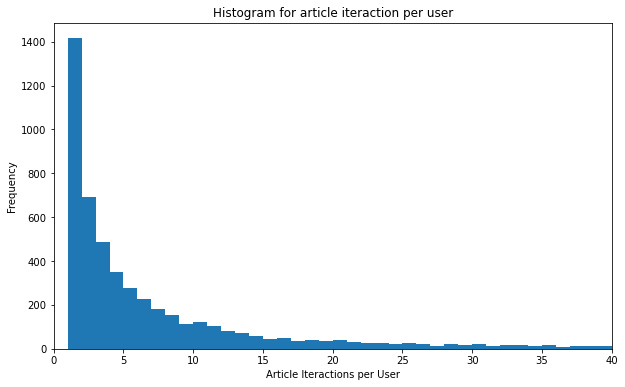

In [5]:
fig, ax = plt.subplots(figsize=[10,6])
df.groupby(['email'])['title'].count().plot(kind='hist',bins=np.arange(0,150))
ax.set_xlim(0,40)
ax.set_xlabel('Article Iteractions per User')
ax.set_title('Histogram for article iteraction per user');

In [6]:
# Fill in the median and maximum number of user_article interactios below

median_val = np.median(df.groupby(['email'])['title'].count().values) # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = np.max(df.groupby(['email'])['title'].count().values)# The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [7]:
# Find and explore duplicate articles

In [8]:
print(f'Number of rows in DataFrame: {df_content.shape[0]}')
print(f'Number of unique article ids: {df_content.article_id.nunique()}')
print(f'Number of Unique Full Names: {df_content.doc_full_name.nunique()}')
print(f'Number of Unique Doc Descriptions: {df_content.doc_description.nunique()}')
print(f'Number of Unique Doc Bodys: {df_content.doc_body.nunique()}')

Number of rows in DataFrame: 1056
Number of unique article ids: 1051
Number of Unique Full Names: 1051
Number of Unique Doc Descriptions: 1022
Number of Unique Doc Bodys: 1036


This would suggest that there are a number of duplicates. Lets review those entries with the same descriptions.

In [9]:
# There are 5 article numbers which appear to be duplicated
df_content.groupby('article_id')['doc_full_name'].count()[df_content.groupby('article_id')['doc_full_name'].count() > 1]

article_id
50     2
221    2
232    2
398    2
577    2
Name: doc_full_name, dtype: int64

In [10]:
df_content[df_content['article_id'] == 232]

,doc_body,doc_description,doc_full_name,doc_status,article_id
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [11]:
df_content[df_content['article_id'] == 50].iloc[0]['doc_body'].split('Graph-based')[1]

' machine learning is a powerful tool that can easily be merged\r\ninto ongoing efforts. Using modularity as an optimization goal provides a\r\nprincipled approach to community detection. Local modularity increment can be\r\ntweaked to your own dataset to reflect interpretable quantities. This is useful\r\nin many scenarios, making it a prime candidate for your everyday toolbox.Many important problems can be represented and studied using graphs — social\r\nnetworks, interacting bacterias, brain network modules, hierarchical image\r\nclustering and many more.\r\n\r\nIf we accept graphs as a basic means of structuring and analyzing data about the\r\nworld, we shouldn’t be surprised to see them being widely used in Machine\r\nLearning as a powerful tool that can enable intuitive properties and power a lot\r\nof useful features. '

In [12]:
t1 = df_content[df_content['article_id'] == 232].iloc[0]['doc_body'].split('SELF-SERVICE DATA')[1].split()

In [13]:
t2 = df_content[df_content['article_id'] == 232].iloc[1]['doc_body'].split('SELF-SERVICE DATA')[1].split()

When exploring these entries, although the article_id is the same, the content in the body is different for some (article id 50), others (article id 232) it is very similar with only a few words different.

In [14]:
#Many duplicated doc_descriptions, but many of these are monthly reports/magazines/blogs etc
df_content.groupby('doc_description')[['doc_full_name']].count().sort_values(by='doc_full_name',ascending=False)

,doc_full_name
doc_description,
Here’s this week’s news in Data Science and Big Data.,16
Here’s this week’s news in Data Science and Big Data.,10
Interesting data science links from around the web.,2
How to build SQL Queries in a Scala notebook using IBM Analytics for Apache Spark,2
"Today’s world of data science leverages data from various sources. Commonly, these sources are Hadoop File System, Enterprise Data Warehouse, Relational Database systems, Enterprise file systems, etc…",2
...,...
"In his latest Write Stuff article Robert Wysocki explains PostgreSQL backups, how to pick which ones to do and what the pros and cons are.",1
"In my last blog, we looked at moving data from Amazon DynamoDB to Cloudant or CouchDB. In this article we’re going to look at extracting data from Microsoft Azure’s DocumentDB service. The tool makes…",1
"In my previous life I was a particle physicist, searching for very rare nuclear reactions (in order to count neutrinos from the sun and search for dark matter). I had forgotten, until very recently…",1


In [15]:
df_content[df_content['doc_description'] == 'Here’s this week’s news in Data Science and Big Data.']

,doc_body,doc_description,doc_full_name,doc_status,article_id
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
78,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (May 16, 2017)",Live,78
191,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (March 28, 2017)",Live,191
210,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (February 14, 2017)",Live,210
288,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (January 31, 2017)",Live,288
304,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (August 30, 2016)",Live,304
560,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 4, 2017)",Live,559
727,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (March 7, 2017)",Live,725
839,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (October 05, 2016)",Live,836
867,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (February 21, 2017)",Live,864


It was decided to remove ariticle ids which are the same.

In [16]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset='article_id',inplace=True)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [17]:
unique_articles = df.article_id.nunique() # The number of unique articles that have at least one interaction
total_articles = df_content.shape[0] # The number of unique articles on the IBM platform
unique_users = df.email.nunique() # The number of unique users
user_article_interactions = df.shape[0] # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [19]:
most_viewed_article_id = str(df.groupby('article_id')['email'].count().sort_values(ascending=False).index[0]) # The most viewed article in the dataset as a string with one value following the decimal 
max_views = df.groupby('article_id')['email'].count().sort_values(ascending=False).values[0] # The most viewed article in the dataset was viewed how many times?

In [20]:
## map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


Inbuilt check for Udacity Submission

In [31]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

The data doesn't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

The function below will return the **n** top articles ordered with most interactions as the top.

In [21]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles = list(df.groupby('title')['user_id'].count().sort_values(ascending=False).index[:n])
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles = list(df.groupby('article_id')['user_id'].count().sort_values(ascending=False).index[:n])
 
    return top_articles # Return the top article ids

In [22]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


Inbuilt test for Udacity Submission

In [23]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>

`1.` To build our collaborative filtering recommendation engine, we will first have to be able to classify whether users are similar. To to this, we will create a user article matrix. 

* Each user will appear just once
* Each article will appear just once

This matrix will then enable us to check the similarity between users by comparing the dot product of the user article matrix with itself transpossed. 

users who have interacted (read) the highest number of similar articles will be deemed most similar for this analysis. 

Given a user_id, we can then search for the closest neighbor (most similar user) and check to see if there are any articles which they have read, which our given user_id has not read. This will allow us to recommend new articles.

In [35]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    df_test = df.groupby(['user_id','article_id'])[['title']].count()
    df_test['title'] = 1
    user_item_df = df_test.unstack()
    user_item_df.replace(to_replace = np.nan, value=0, inplace=True)
    user_item_df.columns = user_item_df.columns.droplevel()
    
    return user_item_df # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [36]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` The function below takes a user_id and provides an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

In [37]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # Make user array
    users_array = np.array(user_item.index)
    
    # compute similarity of each user to the provided user
    sims = np.dot(user_item,np.transpose(user_item))
    
    user_sim_dict = {}
    for us, sim in zip(users_array, sims[user_id-1]):
        user_sim_dict[us] = sim

    # sort by similarity
    most_sim_users = [item[0] for item in sorted(user_sim_dict.items(), key = lambda x: x[1], reverse=True)]
    # create list of just the ids
   
    # remove the own user's id
    most_sim_users.remove(user_id)
    
    return  most_sim_users# return a list of the users in order from most to least similar

In [38]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 49]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` The functions below return the articles you would recommend to a user

In [39]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    article_names = list(set(df[df.article_id.isin(article_ids)]['title'].values))
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    #Get columns of user_item_mat
    cols = np.array(user_item.columns)
    
    # filter row of matrix, boolean where == 1, convert to np array, find idx of where TRUE, 
    article_ids_float = list(cols[np.where(np.array(user_item.loc[user_id] == 1) == True)[0]])
    article_ids_str = [str(i) for i in article_ids_float]
       
    
    article_names = list(set(df[df['article_id'].isin(article_ids_str)]['title'].values))
    
    return article_ids_str, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    
    # Find articles already viewed
    viewed_ids = get_user_articles(user_id, user_item=user_item)[0]
    
    #Find similar users
    similar_users = find_similar_users(user_id)
    
    recs = []
    for user in similar_users:
        #Check if recs met
        if len(recs) < m:
            # Find out what they have seen
            for article in get_user_articles(user)[0]:
                if len(recs) == m:
                    break
                else:
                    if article not in viewed_ids or recs:
                        recs.append(article)
    
    return recs # return your recommendations for this user_id    

In [40]:
get_user_articles(20)

(['1320.0', '232.0', '844.0'],
 ['self-service data preparation with ibm data refinery',
  'use the cloudant-spark connector in python notebook',
  'housing (2015): united states demographic measures'])

In [41]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['a tensorflow regression model to predict house values',
 'recommender systems: approaches & algorithms',
 'data tidying in data science experience',
 'airbnb data for analytics: vancouver listings',
 'access db2 warehouse on cloud and db2 with python',
 '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
 'airbnb data for analytics: mallorca reviews',
 '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
 'tensorflow quick tips',
 'analyze facebook data using ibm watson and watson studio']

In [42]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0']),"Oops doesn\'t look right"
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function.

In [43]:
def find_similar_users2(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # Make user array
    users_array = np.array(user_item.index)
    
    # compute similarity of each user to the provided user
    sims = np.dot(user_item,np.transpose(user_item))
    
    user_sim_dict = {}
    for us, sim in zip(users_array, sims[user_id-1]):
        user_sim_dict[us] = sim

    # sort by similarity
    most_sim_users = sorted(user_sim_dict.items(), key = lambda x: x[1], reverse=True)
    
    # Create pandas dataframe of user_ids, similarity score, avoiding 1st value which is user_id
    # All sort by similarity and then by num_interactions
    new_df = {'neighbor_id':[user[0] for user in most_sim_users[1:]],
              'similarity':[user[1] for user in most_sim_users[1:]],
              'num_interactions':[user_item.loc[user[0]].sum() for user in most_sim_users[1:]]
             }.sort_values(by=['similarity','num_interactions'],ascending=False)
    
    # Add column for number of interactions
    
    new_df = pd.DataFrame(new_df)
    return  new_df# return a list of the users in order from most to least similar

In [44]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
        # Make user array
    users_array = np.array(user_item.index)
    
    # compute similarity of each user to the provided user
    sims = np.dot(user_item,np.transpose(user_item))
    
    user_sim_dict = {}
    for us, sim in zip(users_array, sims[user_id-1]):
        user_sim_dict[us] = sim

    # sort by similarity
    most_sim_users = sorted(user_sim_dict.items(), key = lambda x: x[1], reverse=True)
    
    # Create pandas dataframe of user_ids, similarity score, avoiding 1st value which is user_id
    # All sort by similarity and then by num_interactions
    new_df = {'neighbor_id':[user[0] for user in most_sim_users[1:]],
              'similarity':[user[1] for user in most_sim_users[1:]],
              'num_interactions':[user_item.loc[user[0]].sum() for user in most_sim_users[1:]]
             }
    
    # Add column for number of interactions
    
    neighbors_df = pd.DataFrame(new_df)
    neighbors_df = neighbors_df.sort_values(by=['similarity','num_interactions'],ascending=False)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    # Find articles already viewed by user
    viewed_ids = get_user_articles(user_id, user_item=user_item)[0]
    
    recs = []
    
    for user in get_top_sorted_users(user_id)['neighbor_id']:
        if recs == m:
            break
        else:
            article_ids = df[df['user_id'] == 1].groupby('article_id')[['title']].count().sort_values(by='title',ascending=False).index
            for art_id in article_ids:
                if len(recs) == m:
                    break
                else:
                    if art_id not in viewed_ids or recs:
                        recs.append(art_id)
    
    rec_names = [df[df['article_id'] == ids]['title'].values[0] for ids in recs]
    
    return recs, rec_names

In [45]:
# Quick spot check for Udacity Submission
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1052.0', '1363.0', '1431.0', '1430.0', '585.0', '1406.0', '668.0', '310.0', '1185.0', '1183.0']

The top 10 recommendations for user 20 are the following article names:
['access db2 warehouse on cloud and db2 with python', 'predict loan applicant behavior with tensorflow neural networking', 'visualize car data with brunel', 'using pixiedust for fast, flexible, and easier data analysis and experimentation', 'tidyverse practice: mapping large european cities', 'uci: iris', 'shiny: a data scientist’s best friend', 'time series prediction using recurrent neural networks (lstms)', 'classify tumors with machine learning', 'categorize urban density']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [48]:
### Tests with a dictionary of results

user1_most_sim = find_similar_users(1)[0] # Find the user that is most similar to user 1 
user131_10th_sim = find_similar_users(131)[9]# Find the 10th most similar user to user 131

In [49]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**

Because the user is new, we won't be able to recommend articles based on collaborative filtering because they will not be similar to any other user. The best option is to simply recommend the top rated (most viewed) articles. These have the highest probability of being well received by the user.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [46]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)# Your recommendations here

In [47]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations </a>

**The bulk of the work for the LDA model was developed in a separate notebook** `LDA_IBM_Classification.ipynb`. For details on how the model was optimised for number of topics and removal of unnecessary stop words and more please see notebook.

Another method used to make recommendations is to perform a ranking of the highest ranked articles associated with some term. This is a content based recommendation.

In the below recommendation engine, we will apply some natural language processing to the body of the documents in an antempt to classify them. Once classified, it will enable us to determine similarity of other documents and recommend them.

`1.Text Preprocessing`
The first step in this process is to pre-process the text in our documents. This quality of the preprocessing is an vital part of the analyis to ensure meaningful results are obtained from the NLP.

Steps 
- Define Stop Words
- Tokenize
- Remove stop words
- Create bigrams
- Lemmatization
- Create Dictionary and Corpus

`2. Build Model`
Use LDA Model to classify docs into Topics

`3. Evaluate Model`
Then visualize the topics using pyLDAvis and check Coherance and perplexity scores. 

Iteratively improve the model by adding more stop words, changing threshold for bigrams, finding optimum number of topics, sanity checkin the topics that are created.

`4. Utilise Final Model to Classify Articles`
Utilise final model to classify the article on topic percentage contributions. This will allow an article topic matrix to be generated. Taking the RMS of the dot product of this matrix with its transpose will show the similarity of articles. Those with smallest difference will be most similar.

When given an article, it is then possible to provide a list of similar articles. 

When given an article and a user, you can then suggest similar articles which the user hasn't seen.

In [48]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# This list of stop words was built up incrementally
additional_stops = (['add',
                     'close',
                     'click',
                     'datum',
                     'document',
                     'duration',
                     'email',
                     'go',
                     'get',
                     'guide',
                     'index',
                     'http',
                     'less',
                     'like',
                     'load',
                     'loading',
                     'login',
                     'name',
                     'make',
                     'more',
                     'new',
                     'one',
                     'pass',
                     'point',
                     'queue',
                     'show',
                     'self',
                     'service',
                     'sign',
                     'signout',
                     'start',
                     'starting',
                     'stop',
                     'subscribe',
                     'undo',
                     'use',
                     'user',
                     'using',
                     'video',
                     'view',
                     'watch',
                     'work'])

In [50]:
# Convert to list
data = list(df_content.doc_body.values)

In [51]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [52]:
data_words = list(sent_to_words(data))

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=75) # higher threshold fewer phrases.

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in doc if word not in stop_words and len(word)>2] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def lemmatization(texts):
    #instantiate word lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    return [[lemmatizer.lemmatize(word) for word in doc] for doc in texts]

# Remove stop words
data_without_stops = remove_stopwords(data_words)

# Form Bigrams
data_with_bigrams = make_bigrams(data_without_stops)

#instantiate word lemmatizer
data_lemmatized = lemmatization(data_with_bigrams)

In [53]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [54]:
# Import topics determined by LDA Analysis
topics_df = pd.read_csv('Topics_df.csv')
del topics_df['Unnamed: 0']

In [55]:
topics_df

,TopicId,Name
0,0,Training_Machine_Learning_Algorithm
1,1,Data_Analytics_IBM_Spark
2,2,Cloudant_Database
3,3,rstudio
4,4,Graph_Theory
5,5,Redis_Database
6,6,DataScience_MachineLearning
7,7,EDA_Aggregating_Data
8,8,IBM_Watson
9,9,MongoDB_Database


In [61]:
# LDA Model - Importing Model which was optimised in LDA_IBM_Classification.ipynb
lda_model = joblib.load('LDA_Topic_Classifier.pkl')

In [62]:
def topic_assignment(text, model=lda_model, topics=topics_df['Name']):
    '''
    args: (str) text: text to be classified
          (model) model: lda model
          (list) topics: topics classified by lda
    
    returns: (list)(tuples): Descending List of tuples: [((int) Most relevant topic based on LDA model, (float) Perc Contribution)]
       
    '''
    #Preprocess text
    text = [text]
    data = list(sent_to_words(text))
    data = remove_stopwords(data)
    data = make_bigrams(data)
    data = lemmatization(data)
    data = id2word.doc2bow(data[0])
    
    #Classify Text
    top_topic = sorted(model[data][0], key=lambda x: x[1], reverse=True)
    
    return top_topic

In [63]:
# Create list of relevant topics for each document and include in dataframe
scoring = []
for i, content in enumerate(df_content['doc_body']):
    try:
        scoring.append(topic_assignment(content))
    except:
        print(i)
        scoring.append([np.nan])

df_content['Topic_Rank'] = scoring        

1044
1045
1047
1048


In [64]:
# Helper Function to extract percentage contribution of each topic
def extract_topic_perc(rank, top_id):
    try:
        idx = [top[0] for top in rank].index(top_id)
        return rank[idx][1]
    
    except:
        return 0

In [65]:
# Create Additional Columns for 12 Topics and Allocate Percentage Contributions for each Document
for i in range(12):
    col_title = 'T'+str(i)
    df_content[col_title] = df_content['Topic_Rank'].apply(lambda x: 100*extract_topic_perc(x,i))

In [66]:
# Create article topic matrix - This will be required for checking similarity between docs
cols = ['article_id']
for i in range(12):
    cols.append('T'+str(i))
    
article_topics_mat = df_content[cols].set_index('article_id')

In [67]:
def find_similar_articles(article_id, df=df, df2=df_content, article_item=article_topics_mat, num=10):
    '''
    INPUT:
    article_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook - article_user interactions 
    df2 - (pandas dataframe) df_content as defined at the top of the notebook - article info
    article_item - (pandas dataframe) matrix of article by topics (12): decimal contribution of each topic
    num - Number of article to recommend (int)
    
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    article_id - is an article_id
                    article title
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    #Check that article is within corpus evaluated
    if article_id > 1050 or article_id < 0:
        return 'Not available for Content Based Recommendation'

    # Make article array
    users_array = np.array(article_item.index)
    
    # compute similarity of each article to the provided user
    sims = np.dot(article_item,np.transpose(article_item))
    
    user_sim_dict = {}
    for us, sim in zip(users_array, sims[article_id]):
        # We need to find the rms error 
        user_sim_dict[us] = np.sqrt(np.square(sim - sims[article_id][article_id]))

    # sort by similarity of articles
    most_sim_users = sorted(user_sim_dict.items(), key = lambda x: x[1])
    
    # Create list of title - Not every article has been read by a user
    titles, num_interactions = [], []
    for user in most_sim_users[1:]:
        try:
            titles.append(df[df['article_id'] == str(float(user[0]))]['title'].values[0])
            num_interactions.append(sum(df['article_id'] == str(float(user[0]))))
            
        except:
            titles.append(df2[df2['article_id'] == user[0]]['doc_full_name'].values[0])
            num_interactions.append(0)
    
    # Create pandas dataframe of article_ids, similarity score, avoiding 1st value which is user_id
    # All sort by similarity and then by num_interactions
    new_df = {'Article_Id':[user[0] for user in most_sim_users[1:]],
              'Title': titles,
              'similarity':[user[1] for user in most_sim_users[1:]],
              'num_interactions':num_interactions
             }
    
    # Create DataFrame and SortBy: Similarity then User Interactions

    neighbors_df = pd.DataFrame(new_df)
    neighbors_df = neighbors_df.sort_values(by=['similarity','num_interactions'],ascending=[True,False])
    
    return neighbors_df[['Article_Id','Title']].head(num) # Return the dataframe specified in the doc_string

In [68]:
def recommend_articles_for_user(user_id, article_id, df=df, num=10):
    
    '''
    args
    user_id (int)
    article_id (int)
    df - (dataframe) as defined in notebook
    num (int) number of articles requested
    
    return 
    
    dataframe of article_ids and article_titles
    
    '''
    #Check that article is within corpus evaluated
    if article_id > 1050 or article_id < 0:
        return 'Not available for Content Based Recommendation'
    
    # Find articles already seen by user
    viewed = list(set(df[df['user_id'] == user_id]['article_id'].values))
    # Convert from str to int
    viewed = [int(float(a_id)) for a_id in viewed]
    
    
    # Get user agnostic recommendations based on content
    df_rec = find_similar_articles(article_id, df=df, df2=df_content, article_item=article_topics_mat, num=num)
    
    return df_rec[~df_rec['Article_Id'].isin(viewed)]
    

### Classification of documents

This knowledge based recommendation engine used Latent Dirichlet Allocation(LDA), an unsupervised machine learning algorithm, to identify hidden topics within the corpus of documents. This was particularly useful because the articles in this dataset were not labelled. This problem lended itself well to unsupervised ML for classification.

The LDA approach utilised Python Gensim package. 

**The bulk of the work for the LDA model was developed in a separate notebook** `LDA_IBM_Classification.ipynb`. For details on how the model was optimised for number of topics and removal of unnecessary stop words and more please see notebook.

The process of developing the topics is outlined below:

- Extract document bodies from csv file into a list for processing
- Prepare Stopwords - iterative process which developed over model creation.
- Normalize Text
- Tokenize words
- Creating Bigram Models
- Remove Stopwords, Make Bigrams and Lemmatize
- Create the Dictionary and Corpus needed for Topic Modeling
- Building the LDA Model
- View the topics in LDA model
- Evaluate the Model: Perplexity and Coherence Scores
- Visualize the topics-keywords
- Optimising the number of topics

To expand on a few points from above. After creating the initial model and visualizing the topics, it was evident that there was heavy overlap between the topics which suggested this could be optimised. 

When looking through the words which made up the percentage contribution of the topics, it was evident that some topics could be removed because they were not well defined. I also generated several models, incrementally increasing the number of topics and measuring the coherance. It was evident that 16 topics provided the highest level of coherance but some topics were difficult to classify, so it was opted to choose 12 topics instead. When visualising the topics, these were then clearly separted and well proportioned.

I created a small table to classify the topics which were identified from the LDA analysis. These were:


|Topic_id. | Topic |
| :---:    | :--- |
0 |Training_Machine_Learning_Algorithm
1 |  Data_Analytics_IBM_Spark
2 |                      Cloudant_Database
3 |                                rstudio
4 |                           Graph_Theory
5 |                         Redis_Database
6 |            DataScience_MachineLearning
7 |                   EDA_Aggregating_Data
8 |                             IBM_Watson
9 |                       MongoDB_Database
10|                          Python_Pandas
11|                         Undefined (<1%)


### Building content based recommendation engine

Once the documents were classified the recommendation engine was built. This is defined in the function 

**find_similar_articles(article_id, df=df, df2=df_content, article_item=article_topics_mat, num=10)**

The process followed was:

Given an article_id and a requested number of recommendations, recommend a list of articles based on similarity to the article_id provided and the popularity of the article in the data set (number of user interactions). Articles with an equivalent similarity woudl be then ordered by number of interactions.

The similarity of articles was defined by performing the dot product between the article topic matrix and its transpose. Then the RMS error was found. Those articles with the least error were said to be the most similar.

In [79]:
# make recommendations for a brand new user
# I would have no content to base this off so I would simply provide the most popular articles 

new_user_recs = get_top_article_ids(10)# Your recommendations here

# make a recommendations for a user who only has interacted with article id '980.0'
find_similar_articles(980)


,Article_Id,Title
0,568,Build an iOS 8 App with Bluemix and the Mobile...
1,536,Embed rich reports in your applications
2,697,DataLayer Conference: Online Schema Migrations...
3,149,ibm-cds-labs/hybrid-cloud-tutorial
4,285,Metrics Maven: Crosstab Revisited - Pivoting W...
5,653,create a connection and add it to a project us...
6,499,let data dictate the visualization
7,77,apache spark @scale: a 60 tb+ production use case
8,746,httr 1.2.0
9,786,Getting Connected with RabbitMQ and Elasticsearch


In [80]:
df[df['user_id'] == 50]

,article_id,title,user_id
77,871.0,overfitting in machine learning: what it is an...,50
210,887.0,502 forgetting the past to learn the future...,50
331,871.0,overfitting in machine learning: what it is an...,50
3546,871.0,overfitting in machine learning: what it is an...,50
6922,871.0,overfitting in machine learning: what it is an...,50
20918,347.0,announcing dsx environments in beta!,50
23934,1160.0,analyze accident reports on amazon emr spark,50
24853,34.0,top 10 machine learning use cases: part 1,50


In [69]:
# Recommend articles for user_id 50 given article_id 34
recommend_articles_for_user(50,34)

,Article_Id,Title
0,229,Serverless Data Flow Sequencing with Watson Da...
1,134,"this week in data science (november 01, 2016)"
2,139,Designing the UFC Moneyball
3,121,Picking SQL or NoSQL? – A Compose View
4,995,Visualizing weather data as a PixieApp – IBM W...
5,99,Seven Databases in Seven Days – Day 2: MongoDB
6,795,7292 a dramatic tour through python’s data ...
7,534,dplyr 0.5.0
8,24,The Conversational Interface is the New Paradigm
9,391,Building better database bridges with the new ...


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, we will use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` We have already created a **user_item** matrix above in **question 1** of **Part III** above.  T

In [70]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [71]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [84]:
# Perform SVD on the User-Item Matrix Here
u, s, vt = np.linalg.svd(user_item_matrix)# use the built in to get the three matrices

In [85]:
u.shape

(5149, 5149)

In [86]:
s.shape

(714,)

In [87]:
vt.shape

(714, 714)

**Answer:**

In this application we are able to simply use numpy's inbuild SVD becuase our user article matrix has no missing data. In previous examples (outside of this notebook) there was missing data which would prevent the SVD from converging. In that case we resolved this with funkSVD. 

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

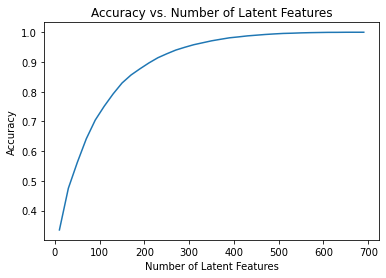

In [88]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [89]:
df.user_id.nunique()

5149

In [73]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = df_test.index
    test_arts = df_test.columns
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [74]:
#Intersect between train and test (These are the users we can predict on)
users_oi = np.intersect1d(df_test.user_id.unique(), df_train.user_id.unique())

In [75]:
#Find index of train set for comparison
idx_train = np.where(np.isin(user_item_train.index,users_oi))[0]

In [76]:
#Find index of Test set for Comparison
idx_test = np.where(np.isin(user_item_test.index,users_oi))[0]

In [77]:
# Check users in test set which are also in train set
x = len(np.intersect1d(df_test.user_id.unique(), df_train.user_id.unique()))
print(f'Users we can make predictions for in the test set: {x}')

Users we can make predictions for in the test set: 20


In [78]:
# Check number of users in the test set that we can't make predictions for
y = len(df_test.user_id.unique()) - x
print(f'Number of users we can\'t make predictions for: {y}')

Number of users we can't make predictions for: 662


In [79]:
#Check articles in test set which are also in train set which allow us to predict on them
z = len(np.intersect1d(df_test.article_id.unique(), df_train.article_id.unique()))
print(f'Article we can make predictions for in the test set: {z}')

Article we can make predictions for in the test set: 574


In [80]:
# Check number of articles in the test set that we can't make predictions for
a = len(df_test.article_id.unique()) - z
print(f'Number of articles in the test set that we can\'t make predictions for: {a}')

Number of articles in the test set that we can't make predictions for: 0


In [81]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, # letter here, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?':a, # letter here, 
    'How many movies can we make predictions for in the test set?':b, # letter here,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?':d # letter here
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [82]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below

In [83]:
u_train.shape

(4487, 4487)

In [84]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

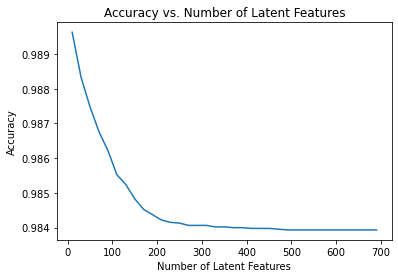

In [85]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    # take dot product of the the matrix but only on user id's that we can predict for.
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))[idx_test]
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix.iloc[idx_train], user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Answer:**
The results of the above are somewhat surprising. I would have expected the accuracy to increase as the number of latent factors increased, but this is not the case. Increasing the latent factors from 10 up to 700 actually resulted in a drop in accuracy of 0.5%.

Perhaps utlising SVD to predict interactions in a binary yes or no is not the best application. Perhaps it will work better predicting values in a continuous range, such as a score between 0 - 10.

Or perhaps the overlap between the train and test set is just too small. Having only 20 users on which to predict from an orignal base of over 5000 unique users is less than ideal.

To evaluate the effectiveness of our recommendation engine, I would preform some A/B testing.

Randomly split users, allocating half to the recommendation engine and half to the control case with no recommendations. We could measure the average number of articles being read by users in both groups. If our recommendation engine was suggesting relevant articles not seen by the users, you would hope that the average user article interactions would increase.

You could also introduce a rating system on articles. In this case you would hope that recommended articles ranked higher on average than articles typically do overall. This information could then be fed back into our recommendation engine to improve the overall output.

In [91]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0

### <a class="anchor" id="References">Part VI: References</a>

In [ ]:
[1] LDA Analysis `LDA_IBM_Classification.ipynb`. For details on how the model was optimised for number of topics and removal of unnecessary stop words and more please see notebook.